In [1]:
import numpy as np
import pandas as pd
import pickle
import regex as re

In [2]:
from preprocessing.parse_rs3_make_objects import EDUPair, EDU
from make_features import load_pairs_target

In [3]:
data_raw = pd.read_csv('../all_data.csv', sep=';')

In [4]:
data_raw.head(10)

,EDU1_pos,EDU1_text,EDU2_pos,EDU2_text,Text_id,Relation
0,1,##### Внутри 22-й Московской международной кни...,2,"проходившей в начале сентября 2009 года на ВВЦ,",0,elaboration_NS
1,1,##### Внутри 22-й Московской международной кни...,3,"работала внутренняя выставка — «Книгабайт»,",0,no_relation
2,1,##### Внутри 22-й Московской международной кни...,4,посвящённая электронному книгоизданию.,0,no_relation
3,2,"проходившей в начале сентября 2009 года на ВВЦ,",3,"работала внутренняя выставка — «Книгабайт»,",0,no_relation
4,2,"проходившей в начале сентября 2009 года на ВВЦ,",4,посвящённая электронному книгоизданию.,0,no_relation
5,3,"работала внутренняя выставка — «Книгабайт»,",4,посвящённая электронному книгоизданию.,0,elaboration_NS
6,5,"И хотя место экспозиция занимала скромное,",6,"да и участников у неё тоже немного,",0,joint_M
7,5,"И хотя место экспозиция занимала скромное,",7,"но по их бодрым, в отличие от большинства изда...",0,concession_SN
8,6,"да и участников у неё тоже немного,",7,"но по их бодрым, в отличие от большинства изда...",0,concession_SN
9,10,"Точнее, услышать что-либо было вообще сложно,",11,поскольку издатели книг бумажных пустились во ...,0,cause-effect_NS


In [5]:
pairs,target = load_pairs_target() 

evaluation_NS
antithesis_SN
Counter({'no_relation': 1866, 'joint_M': 737, 'elaboration_NS': 723, 'same-unit_M': 216, 'attribution_SN': 152, 'contrast_M': 139, 'cause-effect_SN': 82, 'cause-effect_NS': 81, 'condition_SN': 71, 'sequence_M': 66, 'elaboration_SN': 64, 'purpose_NS': 60, 'comparison_M': 47, 'attribution_NS': 44, 'background_SN': 40, 'condition_NS': 38, 'interpretation-evaluation_SN': 37, 'background_NS': 35, 'concession_SN': 29, 'evidence_NS': 28, 'purpose_SN': 28, 'concession_NS': 26, 'restatement_M': 24, 'evidence_SN': 16, 'interpretation-evaluation_NS': 14, 'preparation_SN': 9, 'solutionhood_SN': 2, 'antithesis_NS': 2, 'evaluation_NS': 1, 'antithesis_SN': 1})


## Анализ данных

In [6]:
len(target)

4676

In [7]:
pd.Series(target).value_counts()

no_relation                     1866
joint_M                          737
elaboration_NS                   723
same-unit_M                      216
attribution_SN                   152
contrast_M                       139
cause-effect_SN                   82
cause-effect_NS                   81
condition_SN                      71
sequence_M                        66
elaboration_SN                    64
purpose_NS                        60
comparison_M                      47
attribution_NS                    44
background_SN                     40
condition_NS                      38
interpretation-evaluation_SN      37
background_NS                     35
concession_SN                     29
evidence_NS                       28
purpose_SN                        28
concession_NS                     26
restatement_M                     24
evidence_SN                       16
interpretation-evaluation_NS      14
preparation_SN                     9
antithesis_NS                      2
s

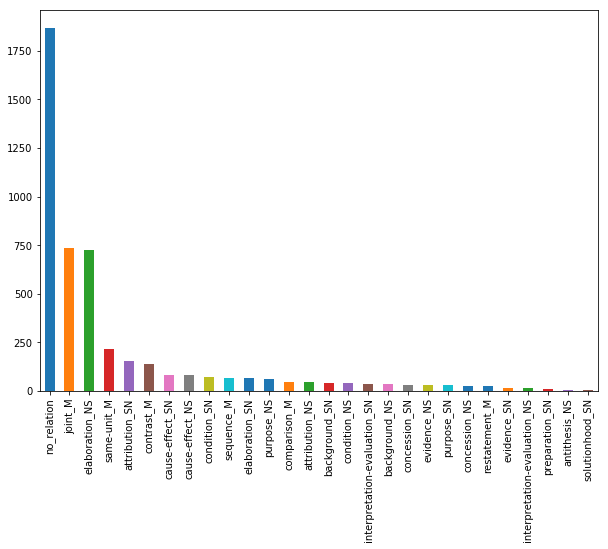

In [9]:
pd.Series(target).value_counts().plot(kind='bar', figsize = (10, 7))

## Признаки

In [10]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack

In [11]:
def iterate_pos(pos_list):
    for pos in pos_list:
        yield pos

In [12]:
c_vect = CountVectorizer(min_df=5, tokenizer=word_tokenize)
pos_vect = CountVectorizer(tokenizer=iterate_pos, lowercase=False)
DataDict = {'edu1_position' : [],
    'edu2_position': [],
    'edu1_endsent' : [], 
    'edu1_startsent' : [],
    'edu2_endsent' : [], 
    'edu2_startsent' : [], 
    'edu1_len' : [], 
    'edu2_len' : [] }
for pair in pairs:
    DataDict['edu1_position'].append(int(pair.edu1.position))
    DataDict['edu2_position'].append(int(pair.edu2.position))
    DataDict['edu1_endsent'].append(int(pair.edu1.sentence_end))
    DataDict['edu2_endsent'].append(int(pair.edu2.sentence_end))
    DataDict['edu1_startsent'].append(int(pair.edu1.sentence_start))
    DataDict['edu2_startsent'].append(int(pair.edu2.sentence_start))
    DataDict['edu1_len'].append(len(pair.edu1.tokens))
    DataDict['edu2_len'].append(len(pair.edu2.tokens))

In [13]:
X = pd.DataFrame(DataDict)

In [14]:
all_texts = [pair.edu1.text for pair in pairs]+[pair.edu2.text for pair in pairs]
c_vect.fit(all_texts)
edus1_vect = c_vect.transform([pair.edu1.text for pair in pairs])
edus2_vect = c_vect.transform([pair.edu2.text for pair in pairs])

In [15]:
all_pos = [pair.edu1.pos for pair in pairs]+[pair.edu2.pos for pair in pairs]
pos_vect.fit(all_pos)
pos1_vect = pos_vect.transform([pair.edu1.pos for pair in pairs])
pos2_vect = pos_vect.transform([pair.edu2.pos for pair in pairs])

In [16]:
X_sparse = csr_matrix(np.array(X))

In [17]:
X_concat = hstack((X_sparse, edus1_vect, edus2_vect, pos1_vect, pos2_vect))

In [18]:
X_concat.shape

(4676, 6252)

## Oversampling minority classes with SMOTE

In [19]:
from imblearn.over_sampling import SMOTE

In [29]:
sm = SMOTE(random_state=669, k_neighbors=1)

In [30]:
X_res, y_res = sm.fit_sample(X_concat, target)

In [31]:
X_res.shape

(52248, 6252)

In [32]:
pd.Series(y_res).value_counts()

joint_M                         1866
sequence_M                      1866
interpretation-evaluation_NS    1866
preparation_SN                  1866
condition_SN                    1866
interpretation-evaluation_SN    1866
antithesis_NS                   1866
purpose_NS                      1866
elaboration_SN                  1866
concession_SN                   1866
attribution_SN                  1866
condition_NS                    1866
cause-effect_NS                 1866
contrast_M                      1866
no_relation                     1866
attribution_NS                  1866
background_NS                   1866
cause-effect_SN                 1866
background_SN                   1866
same-unit_M                     1866
evidence_SN                     1866
restatement_M                   1866
elaboration_NS                  1866
evidence_NS                     1866
solutionhood_SN                 1866
purpose_SN                      1866
comparison_M                    1866
c

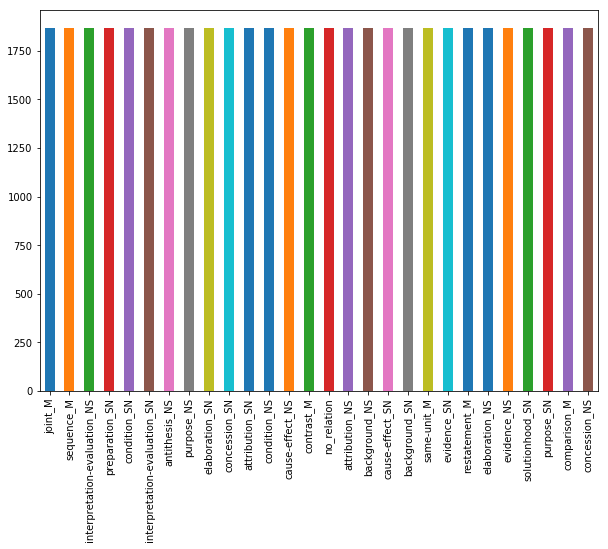

In [33]:
pd.Series(y_res).value_counts().plot(kind='bar', figsize = (10, 7))

## Предсказание

In [34]:
from sklearn.model_selection import cross_val_predict

In [40]:
from sklearn.metrics import classification_report

In [35]:
## RF
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
rf.fit(X_concat, target)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [36]:
pred_rf_sv = cross_val_predict(rf, X_concat, target, cv=5)

/home/lena/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [37]:
def rel_type_only(y):
    return [re.sub('_(SN|NS|M)', '', elem) for elem in y]
def nucl_only(y):
    return [elem.split('_')[1] if elem != 'no_relation' else elem for elem in y ]
def presence_only(y):
    return ['relation' if elem != 'no_relation' else elem for elem in y]

In [38]:
def all_classification_reports(y_true, y_pred):
    print('All together:')
    print(classification_report(y_true, y_pred))
    print('Relation type:')
    print(classification_report(rel_type_only(y_true), rel_type_only(y_pred)))
    print('Nuclearity:')
    print(classification_report(nucl_only(y_true), nucl_only(y_pred)))
    print('Presence of relation:')
    print(classification_report(presence_only(y_true), presence_only(y_pred)))

In [41]:
all_classification_reports(target, pred_rf_sv)

All together:
                              precision    recall  f1-score   support

               antithesis_NS       0.00      0.00      0.00         2
              attribution_NS       1.00      0.05      0.09        44
              attribution_SN       0.33      0.01      0.03       152
               background_NS       0.00      0.00      0.00        35
               background_SN       0.00      0.00      0.00        40
             cause-effect_NS       0.00      0.00      0.00        81
             cause-effect_SN       0.00      0.00      0.00        82
                comparison_M       0.00      0.00      0.00        47
               concession_NS       0.00      0.00      0.00        26
               concession_SN       0.00      0.00      0.00        29
                condition_NS       0.00      0.00      0.00        38
                condition_SN       0.00      0.00      0.00        71
                  contrast_M       0.00      0.00      0.00       139
     

/home/lena/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
pred_rf_balanced = cross_val_predict(rf, X_res, y_res, cv=5)

In [43]:
all_classification_reports(y_res, pred_rf_balanced)

All together:
                              precision    recall  f1-score   support

               antithesis_NS       1.00      1.00      1.00      1866
              attribution_NS       1.00      0.98      0.99      1866
              attribution_SN       0.99      0.95      0.97      1866
               background_NS       1.00      0.99      0.99      1866
               background_SN       1.00      0.99      0.99      1866
             cause-effect_NS       1.00      0.97      0.98      1866
             cause-effect_SN       1.00      0.98      0.99      1866
                comparison_M       1.00      0.98      0.99      1866
               concession_NS       0.99      0.99      0.99      1866
               concession_SN       1.00      0.99      1.00      1866
                condition_NS       0.99      0.99      0.99      1866
                condition_SN       0.99      0.98      0.99      1866
                  contrast_M       0.99      0.96      0.97      1866
     